In [1]:
from src.dataset import CustomDataset
from src.models.resnet import resnet18, resnet34, resnet50, wide_resnet50_2
from src.models.de_resnet import de_resnet18, de_resnet34, de_wide_resnet50_2, de_resnet50
from test import evaluation
from torch.utils.data import DataLoader,DataLoader2
import torch.nn as nn 
import torch.nn.functional as F 
import torch 
import torchvision.transforms as transforms 
import yaml 
from tqdm.auto import tqdm 
import numpy as np 
import random 
from tqdm import tqdm 
import matplotlib.pyplot as plt 

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def loss_function(a, b):
    #mse_loss = torch.nn.MSELoss()
    cos_loss = torch.nn.CosineSimilarity()
    loss = 0
    for item in range(len(a)):
        #print(a[item].shape)
        #print(b[item].shape)
        #loss += 0.1*mse_loss(a[item], b[item])
        loss += torch.mean(1-cos_loss(a[item].view(a[item].shape[0],-1),
                                      b[item].view(b[item].shape[0],-1)))
    return loss

def loss_concat(a, b):
    mse_loss = torch.nn.MSELoss()
    cos_loss = torch.nn.CosineSimilarity()
    loss = 0
    a_map = []
    b_map = []
    size = a[0].shape[-1]
    for item in range(len(a)):
        #loss += mse_loss(a[item], b[item])
        a_map.append(F.interpolate(a[item], size=size, mode='bilinear', align_corners=True))
        b_map.append(F.interpolate(b[item], size=size, mode='bilinear', align_corners=True))
    a_map = torch.cat(a_map,1)
    b_map = torch.cat(b_map,1)
    loss += torch.mean(1-cos_loss(a_map,b_map))
    return 


#def run 
cfg = yaml.load(open('./save_models/MVtecAD/bottle/config.yaml','r'), Loader=yaml.FullLoader)
setup_seed(cfg['TRAIN']['seed'])
device = 'cuda:0'
trainloader = DataLoader(
                dataset = CustomDataset(
                                        root          = cfg['DATA']['datadir'],
                                        img_size      = cfg['DATA']['imgsize'],
                                        transform     = transforms.Compose([transforms.ToTensor()]),
                                        img_cls       = cfg['DATA']['imgcls'],
                                        mode          = cfg['DATA']['mode'],
                                        train         = True 
                                        ),
                batch_size = cfg['TRAIN']['batchsize'], 
                shuffle    = True
                )
                    
testloader = DataLoader(
                dataset = CustomDataset(
                                        root          = cfg['DATA']['datadir'],
                                        img_size      = cfg['DATA']['imgsize'],
                                        transform     = transforms.Compose([transforms.ToTensor()]),
                                        img_cls       = cfg['DATA']['imgcls'],
                                        mode          = cfg['DATA']['mode'],
                                        train         = False
                                        ),
                #batch_size = cfg['TRAIN']['batchsize'], 
                batch_size = 1,
                shuffle    = False
                )
cfg['SAVE']['savedir'] = os.path.join(cfg['SAVE']['savedir'],cfg['DATA']['dataset'],cfg['DATA']['imgcls'])
bn = torch.load(os.path.join(cfg['SAVE']['savedir'] ,'best_bn.pt')).to(device)
decoder = torch.load(os.path.join(cfg['SAVE']['savedir'] ,'best_decoder.pt')).to(device)
encoder,_ = resnet34(pretrained=True)
encoder = encoder.to(device)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cal_anomaly_map(fs_list, ft_list, out_size=224, amap_mode='mul'):
    if amap_mode == 'mul':
        anomaly_map = np.ones([out_size, out_size])
    else:
        anomaly_map = np.zeros([out_size, out_size])
    a_map_list = []
    for i in range(len(ft_list)):
        fs = fs_list[i]
        ft = ft_list[i]
        #fs_norm = F.normalize(fs, p=2)
        #ft_norm = F.normalize(ft, p=2)
        a_map = 1 - F.cosine_similarity(fs, ft) #loss 계산 
        a_map = torch.unsqueeze(a_map, dim=1)
        a_map = F.interpolate(a_map, size=out_size, mode='bilinear', align_corners=True)
        a_map = a_map[0, 0, :, :].to('cpu').detach().numpy()
        a_map_list.append(a_map)
        if amap_mode == 'mul':
            anomaly_map *= a_map
        else:
            anomaly_map += a_map
    return anomaly_map, a_map_list

def show_cam_on_image(img, anomaly_map):
    #if anomaly_map.shape != img.shape:
    #    anomaly_map = cv2.applyColorMap(np.uint8(anomaly_map), cv2.COLORMAP_JET)
    cam = np.float32(anomaly_map)/255 + np.float32(img)/255
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def min_max_norm(image):
    a_min, a_max = image.min(), image.max()
    return (image-a_min)/(a_max - a_min)

def cvt2heatmap(gray):
    heatmap = cv2.applyColorMap(np.uint8(gray), cv2.COLORMAP_JET)
    return heatmap

# Metrics 

In [4]:
from scipy.ndimage import gaussian_filter
from test import compute_pro
from sklearn.metrics import roc_auc_score,auc 
bn.eval()
decoder.eval()
encoder.eval()

gt_list_px = []
pr_list_px = []
gt_list_sp = []
pr_list_sp = []
aupro_list = []

with torch.no_grad():
    for img,gt,label in testloader:
        
        img = img.to(device)
        inputs = encoder(img)
        outputs = decoder(bn(inputs))
        anomaly_map,_ = cal_anomaly_map(inputs,outputs,img.shape[-1],amap_mode='a')
        anomaly_map = gaussian_filter(anomaly_map, sigma=4)
        gt[gt > 0.5] = 1
        gt[gt <= 0.5] = 0
        if label.item()!=0:
            aupro_list.append(compute_pro(gt.squeeze(0).cpu().numpy().astype(int),
                                            anomaly_map[np.newaxis,:,:]))
        gt_list_px.extend(gt.cpu().numpy().astype(int).ravel())
        pr_list_px.extend(anomaly_map.ravel())
        gt_list_sp.append(np.max(gt.cpu().numpy().astype(int)))
        pr_list_sp.append(np.max(anomaly_map))
        
    auroc_px = round(roc_auc_score(gt_list_px, pr_list_px), 3)
    auroc_sp = round(roc_auc_score(gt_list_sp, pr_list_sp), 3)
    aupro_px = round(np.mean(aupro_list),3)
print('Pixel Auroc:{:.3f}, Sample Auroc{:.3f}, Pixel Aupro{:.3}'.format(auroc_px, auroc_sp, aupro_px)) 

Pixel Auroc:0.985, Sample Auroc0.931, Pixel Aupro0.914


# Visualization 

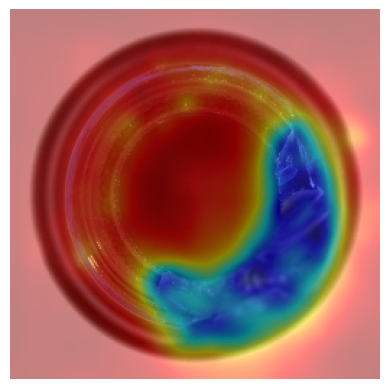

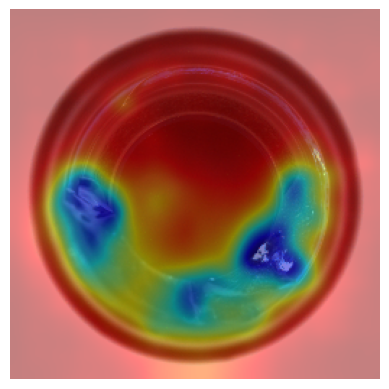

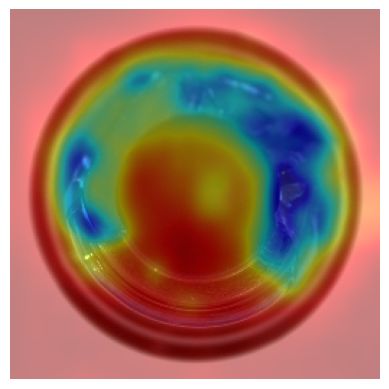

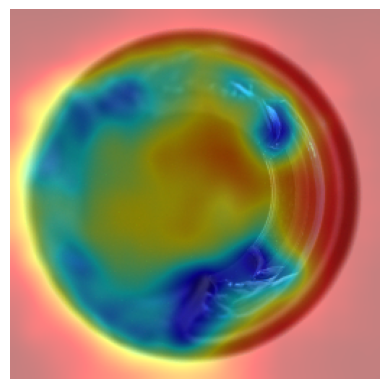

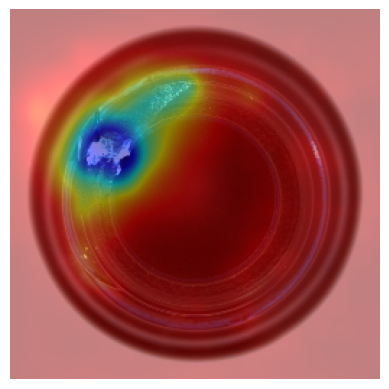

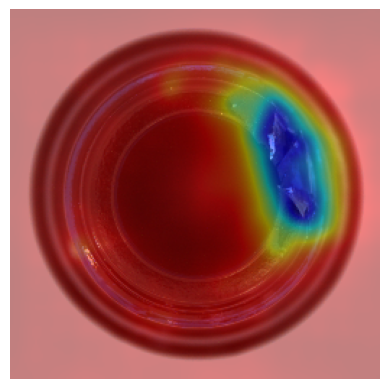

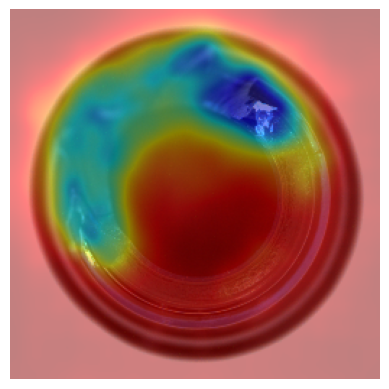

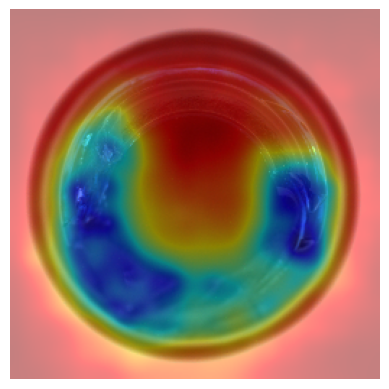

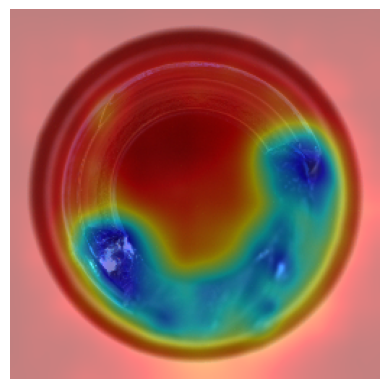

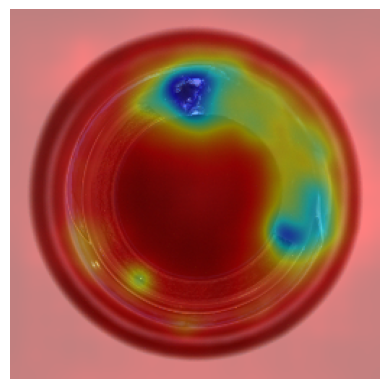

In [3]:
from scipy.ndimage import gaussian_filter
from test import compute_pro
from sklearn.metrics import roc_auc_score,auc 
import cv2 
bn.eval()
decoder.eval()
encoder.eval()

gt_list_px = []
pr_list_px = []
gt_list_sp = []
pr_list_sp = []
aupro_list = []

n = 0 
with torch.no_grad():
    for img,gt,label in testloader:
        if label.item() == 1:
            img = img.to(device)
            inputs = encoder(img)
            outputs = decoder(bn(inputs))
            anomaly_map,amap_list = cal_anomaly_map(inputs,outputs,img.shape[-1],amap_mode='a')
            anomaly_map = gaussian_filter(anomaly_map, sigma=4)
            ano_map = min_max_norm(anomaly_map)
            ano_map = cvt2heatmap(ano_map*255)
            img = cv2.cvtColor(img.permute(0, 2, 3, 1).cpu().numpy()[0] * 255, cv2.COLOR_BGR2RGB)
            img = np.uint8(min_max_norm(img)*255)
            ano_map = show_cam_on_image(img, ano_map)
            plt.imshow(ano_map)
            plt.axis('off')
            plt.show()
            n +=1 
            
            if n == 10:
                break 
            

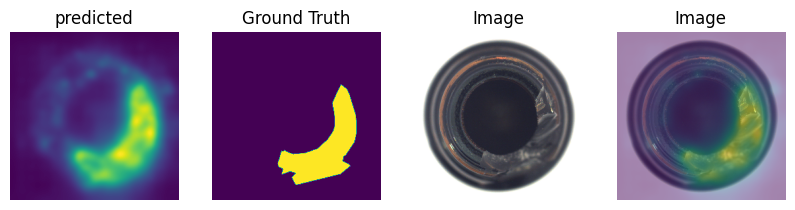

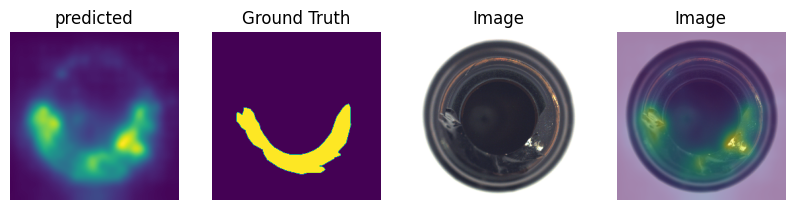

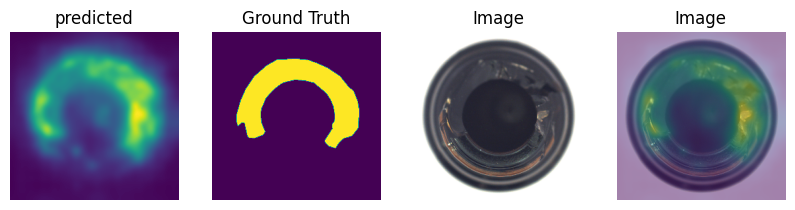

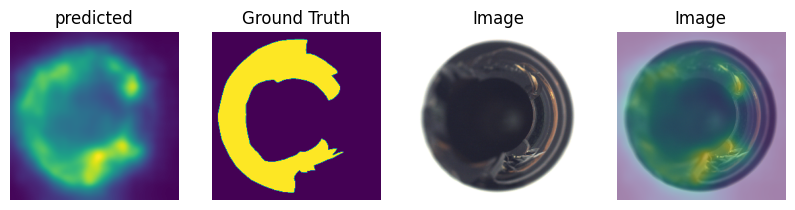

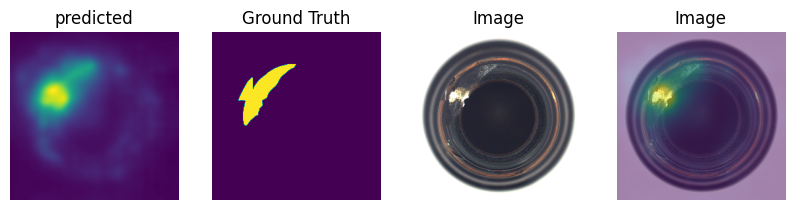

: 

In [4]:
from scipy.ndimage import gaussian_filter
from test import compute_pro
from sklearn.metrics import roc_auc_score,auc 
import cv2 
bn.eval()
decoder.eval()
encoder.eval()

gt_list_px = []
pr_list_px = []
gt_list_sp = []
pr_list_sp = []
aupro_list = []

n = 0 
with torch.no_grad():
    for img,gt,label in testloader:
        if label.item() == 1:
            img = img.to(device)
            inputs = encoder(img)
            outputs = decoder(bn(inputs))
            anomaly_map,amap_list = cal_anomaly_map(inputs,outputs,img.shape[-1],amap_mode='a')
            anomaly_map = gaussian_filter(anomaly_map, sigma=4)
            anomaly_map = min_max_norm(anomaly_map)
            fig,axes = plt.subplots(1,4,figsize=(10,10))
            axes[0].imshow(anomaly_map)
            axes[0].set_title('predicted')
            axes[0].axis('off')

            axes[1].imshow(torch.permute(gt.squeeze(0),dims=(1,2,0)))
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')

            axes[2].imshow(torch.permute(img.squeeze(0),dims=(1,2,0)).detach().cpu().numpy())
            axes[2].axis('off')
            axes[2].set_title('Image')


            axes[3].imshow(cv2.resize(torch.permute(img.squeeze(0),dims=(1,2,0)).detach().cpu().numpy(),dsize=(256,256)))
            axes[3].imshow(anomaly_map,alpha=0.5)
            axes[3].axis('off')
            axes[3].set_title('Image')
            plt.show()
            n +=1 
            if n == 5:
                break 